# Divisão e Visualização de Dados
Este notebook realiza a divisão dos dados em conjuntos de treino, validação e teste, além de fornecer ferramentas para visualização dos dados.

In [36]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import torch
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F

# Caminhos
ROOT_DIR = "frames"  # Pasta com os frames
LABELS_FILE = "OSATS_clean.xlsx"  # Arquivo com os rótulos

# Proporções para divisão
TRAIN_RATIO = 0.7
VAL_RATIO = 0.15
TEST_RATIO = 0.15

BATCH_SIZE = 8



# Transformações
mean = [0.5874, 0.5624, 0.6087]
std = [0.1055, 0.0968, 0.0939]
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

class VideoSequenceDataset(Dataset):
    """Dataset para carregar sequências de frames de vídeos."""
    def __init__(self, root_dir, labels_file, video_ids, sequence_length=16, stride=8, transform=None):
        self.root_dir = root_dir
        self.labels = pd.read_excel(labels_file)
        self.video_ids = video_ids
        self.sequence_length = sequence_length
        self.stride = stride
        self.transform = transform
        self.sequences = []
        
        # Organizar os frames por vídeo
        for video_id in self.video_ids:
            video_frames_dir = os.path.join(self.root_dir, video_id)
            if os.path.exists(video_frames_dir):
                frames = sorted([f for f in os.listdir(video_frames_dir) 
                                if f.endswith(('.jpg', '.png', '.jpeg'))])
                
                # Extrair sequências de frames
                if len(frames) >= sequence_length:
                    for i in range(0, len(frames) - sequence_length + 1, stride):
                        sequence = [os.path.join(video_frames_dir, frames[i+j]) for j in range(sequence_length)]
                        label = self.labels.loc[self.labels['VIDEO'] == video_id, 'GRS'].values[0]
                        self.sequences.append((sequence, label, video_id))
    
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        frame_paths, label, video_id = self.sequences[idx]
        frames = []
        
        for frame_path in frame_paths:
            image = Image.open(frame_path)
            if self.transform:
                image = self.transform(image)
            frames.append(image)
        
        # Empilhar frames em um tensor [sequence_length, channels, height, width]
        frames_tensor = torch.stack(frames)
        
        return frames_tensor, label, video_id


def split_data_by_video(labels_file, train_ratio, val_ratio, test_ratio):
    # Carregar os rótulos
    labels_df = pd.read_excel(labels_file)
    
    # Inicializar listas para os conjuntos
    train_ids, val_ids, test_ids = [], [], []
    
    # Iterar sobre cada classe
    for label in labels_df['GRS'].unique():
        # Filtrar os IDs dos vídeos para a classe atual
        video_ids = labels_df[labels_df['GRS'] == label]['VIDEO'].tolist()
        
        # Verificar se há amostras suficientes para divisão
        if len(video_ids) < 3:  # Se houver menos de 3 vídeos, alocar todos para treino
            train_ids.extend(video_ids)
            continue
        
        # Dividir em treino e restante
        train, temp = train_test_split(video_ids, test_size=(1 - train_ratio), random_state=42)
        
        # Verificar se o restante é suficiente para validação e teste
        if len(temp) < 2:  # Se o restante for menor que 2, alocar tudo para validação
            val_ids.extend(temp)
            continue
        
        # Dividir o restante em validação e teste
        val, test = train_test_split(temp, test_size=(test_ratio / (val_ratio + test_ratio)), random_state=42)
        
        # Adicionar aos conjuntos finais
        train_ids.extend(train)
        val_ids.extend(val)
        test_ids.extend(test)
    
    return train_ids, val_ids, test_ids

def create_sequence_dataloaders(root_dir, labels_file, train_ids, val_ids, test_ids, 
                               transform, sequence_length=16, stride=8, batch_size=4):
    """Cria DataLoaders para sequências de frames."""
    train_dataset = VideoSequenceDataset(root_dir, labels_file, train_ids, 
                                        sequence_length, stride, transform)
    val_dataset = VideoSequenceDataset(root_dir, labels_file, val_ids, 
                                      sequence_length, stride, transform)
    test_dataset = VideoSequenceDataset(root_dir, labels_file, test_ids, 
                                       sequence_length, stride, transform)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    labels_file
    return train_loader, val_loader, test_loader

# Dividir os dados por vídeo
train_ids, val_ids, test_ids = split_data_by_video(LABELS_FILE, TRAIN_RATIO, VAL_RATIO, TEST_RATIO)

# Criar os DataLoaders
sequence_length = 16  # Número de frames em cada sequência
stride = 8  # Sobreposição entre sequências
batch_size = 4  # Tamanho do batch
# Criar DataLoaders para sequências
seq_train_loader, seq_val_loader, seq_test_loader = create_sequence_dataloaders(
    ROOT_DIR, LABELS_FILE, train_ids, val_ids, test_ids, 
    transform, sequence_length, stride, batch_size
)

# Exemplo: verificar tamanhos
print(f"Treino: {len(seq_train_loader.dataset)} frames")
print(f"Validação: {len(seq_val_loader.dataset)} frames")
print(f"Teste: {len(seq_test_loader.dataset)} frames")

Treino: 4794 frames
Validação: 1034 frames
Teste: 1142 frames


Visualizando sequências de treino:


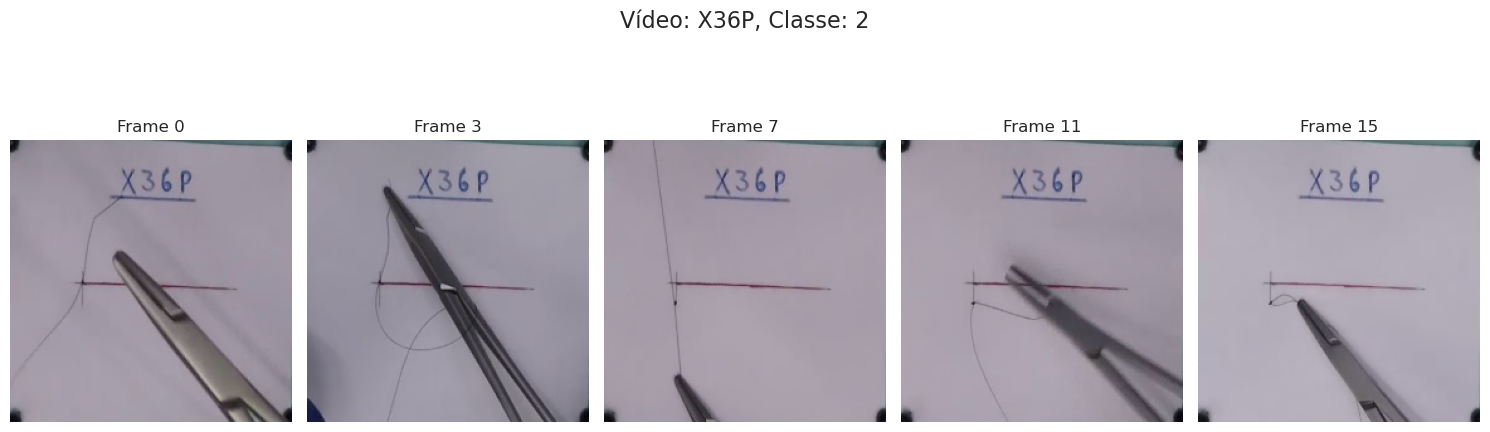

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.728866571073297e-08..0.850980417752266].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.728866571073297e-08..0.7372549391984939].


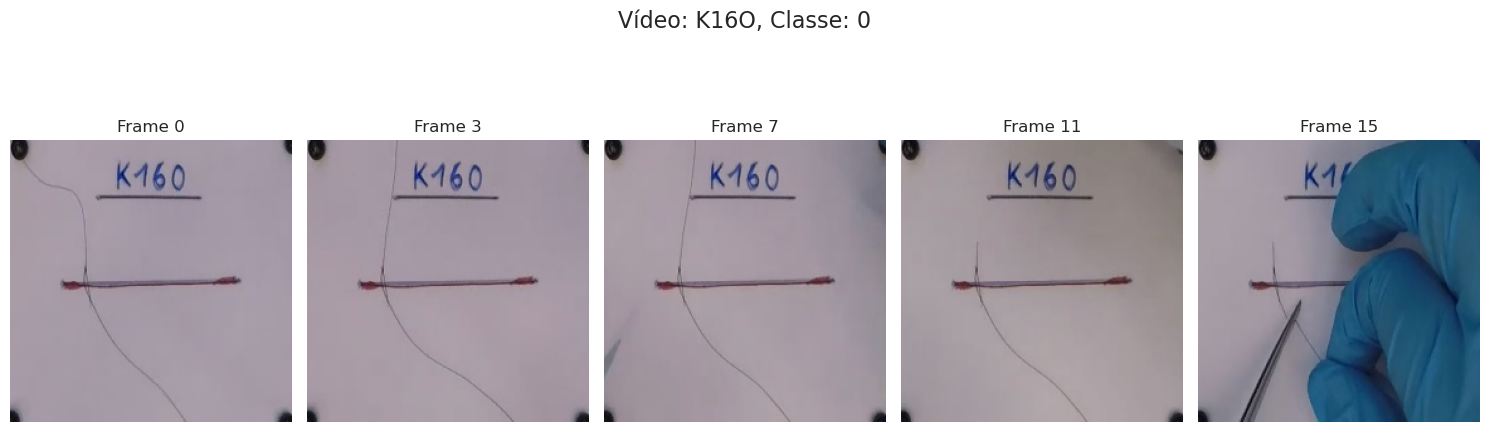

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-9.155273428262944e-09..0.7843137536644935].


Visualizando sequências de validação:


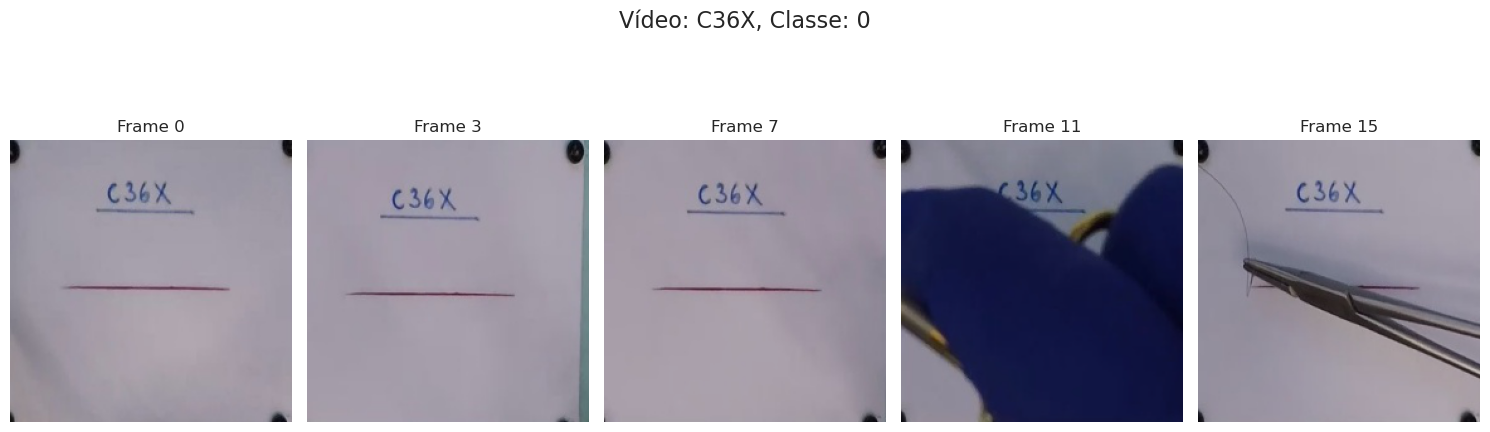

Visualizando sequências de teste:


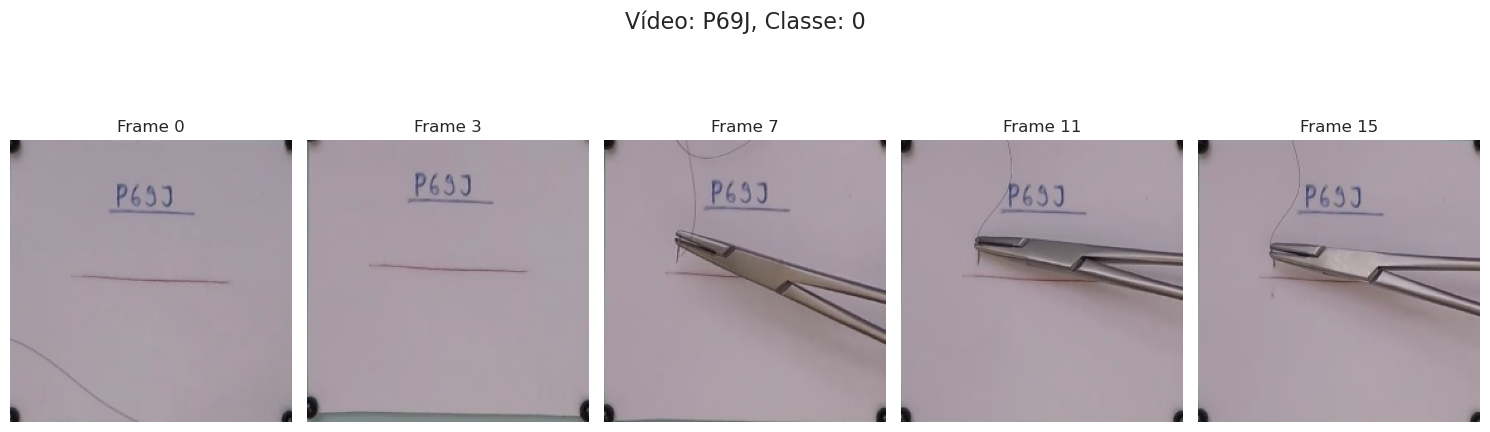

In [37]:
def visualize_sequence_data(loader, num_sequences=2, frames_to_show=5):
    """Visualiza sequências de frames dos vídeos.
    
    Args:
        loader: DataLoader com sequências de frames
        num_sequences: Número de sequências diferentes para visualizar
        frames_to_show: Número de frames de cada sequência para mostrar
    """
    # Obter um batch
    sequences, labels, video_ids = next(iter(loader))
    
    for seq_idx in range(min(num_sequences, len(sequences))):
        # Obter uma sequência
        sequence = sequences[seq_idx]  # [seq_len, C, H, W]
        label = labels[seq_idx].item()
        video_id = video_ids[seq_idx]
        
        # Selecionar frames uniformemente distribuídos na sequência
        seq_len = sequence.shape[0]
        frame_indices = np.linspace(0, seq_len-1, frames_to_show, dtype=int)
        
        # Criar figura para essa sequência
        plt.figure(figsize=(15, 5))
        plt.suptitle(f"Vídeo: {video_id}, Classe: {label}", fontsize=16)
        
        # Mostrar frames selecionados
        for i, frame_idx in enumerate(frame_indices):
            frame = sequence[frame_idx]  # [C, H, W]
            
            plt.subplot(1, frames_to_show, i + 1)
            plt.axis('off')
            # Converter o tensor para imagem
            plt.imshow(frame.permute(1, 2, 0).numpy() * std + mean)
            plt.title(f"Frame {frame_idx}")
            
        plt.tight_layout(rect=[0, 0, 1, 0.95])  # Ajusta o layout para acomodar o título
        plt.show()

# Visualizar dados de treino
print("Visualizando sequências de treino:")
visualize_sequence_data(seq_train_loader, num_sequences=2)

# Visualizar dados de validação
print("Visualizando sequências de validação:")
visualize_sequence_data(seq_val_loader, num_sequences=1)

# Visualizar dados de teste
print("Visualizando sequências de teste:")
visualize_sequence_data(seq_test_loader, num_sequences=1)

In [38]:
def visualize_dataset_split(train_loader, val_loader, test_loader):
    print(f"Quantidade de casos de Treino: {len(train_loader.dataset)}")
    print(f"Quantidade de casos de Validação: {len(val_loader.dataset)}")
    print(f"Quantidade de casos de Teste: {len(test_loader.dataset)}")

    for loader, name in zip([train_loader, val_loader, test_loader], ["Treino", "Validação", "Teste"]):
        batch = next(iter(loader))
        # Verifica se há três elementos no batch (input, label e video_id)
        if len(batch) == 3:
            x, y, _ = batch
        else:
            x, y = batch

        print(f"\n{name}:")
        print(f"Shape tensor batch, input: {x.shape}, output: {y.shape}")
        print(f"Valor máximo no batch: {torch.max(x)}, Valor mínimo no batch: {torch.min(x)}")
        # Converte para numpy; garantindo que o tensor esteja na CPU
        x_np = x.detach().cpu().numpy()
        print(f"Valor máximo após conversão para numpy: {np.max(x_np)}, Valor mínimo: {np.min(x_np)}")
        print(f"Rótulos no batch: {y}")

# Exemplo de uso
visualize_dataset_split(seq_train_loader, seq_val_loader, seq_test_loader)

Quantidade de casos de Treino: 4794
Quantidade de casos de Validação: 1034
Quantidade de casos de Teste: 1142

Treino:
Shape tensor batch, input: torch.Size([4, 16, 3, 224, 224]), output: torch.Size([4])
Valor máximo no batch: 2.5760819911956787, Valor mínimo no batch: -6.482427597045898
Valor máximo após conversão para numpy: 2.5760819911956787, Valor mínimo: -6.482427597045898
Rótulos no batch: tensor([2, 0, 1, 2])

Validação:
Shape tensor batch, input: torch.Size([4, 16, 3, 224, 224]), output: torch.Size([4])
Valor máximo no batch: 4.318100929260254, Valor mínimo no batch: -6.482427597045898
Valor máximo após conversão para numpy: 4.318100929260254, Valor mínimo: -6.482427597045898
Rótulos no batch: tensor([0, 0, 0, 0])

Teste:
Shape tensor batch, input: torch.Size([4, 16, 3, 224, 224]), output: torch.Size([4])
Valor máximo no batch: 3.0622267723083496, Valor mínimo no batch: -6.357138156890869
Valor máximo após conversão para numpy: 3.0622267723083496, Valor mínimo: -6.357138156890

In [39]:
def visualize_data_balance(loader, titulo):
    all_labels = []
    for _, labels, _ in loader:  
        all_labels.extend(labels.numpy())

    sns.set_style('whitegrid')
    print(f"Total de casos em {titulo}: {len(all_labels)}")

    x, y = np.unique(all_labels, return_counts=True)

    print("Classes:", x)
    print("Frequências:", y)
    print("Total:", np.sum(y))

    grafico = sns.barplot(x=x, y=y)
    grafico.set_title(f'Data balance: {titulo}')
    plt.xticks(rotation=70)
    plt.tight_layout()
    plt.show()

# Exemplo de uso
#print("-----------------------------------Treino-----------------------------------")
#visualize_data_balance(seq_train_loader, 'Treino')
#
#print("-----------------------------------Validação-----------------------------------")
#visualize_data_balance(seq_val_loader, 'Validação')
#
#print("-----------------------------------Teste-----------------------------------")
#visualize_data_balance(seq_test_loader, 'Teste')

-----------------------------------Treino-----------------------------------
Total de vídeos em Treino: 130


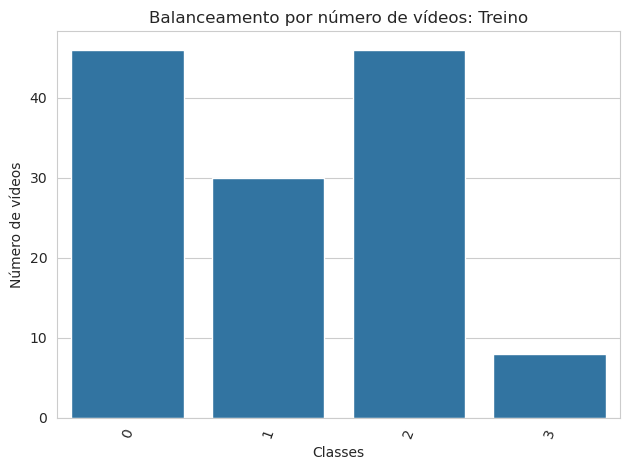

-----------------------------------Validação-----------------------------------
Total de vídeos em Validação: 28


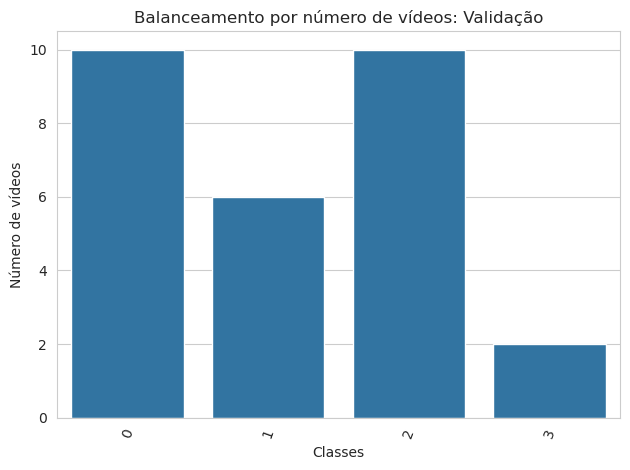

-----------------------------------Teste-----------------------------------
Total de vídeos em Teste: 31


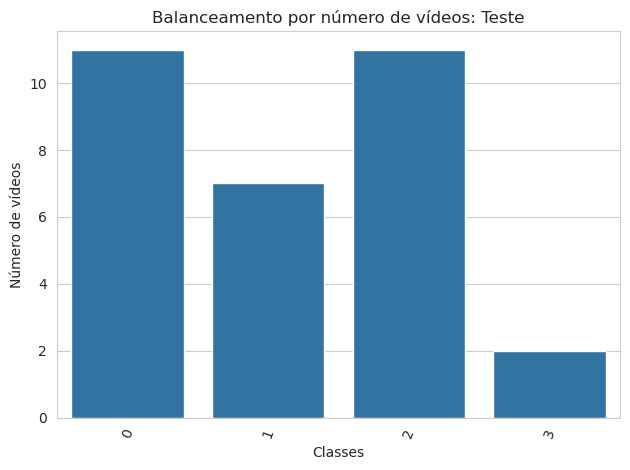

In [40]:
def visualize_video_balance(video_ids, labels_file, titulo):
    labels_df = pd.read_excel(labels_file)
    filtered_labels = labels_df[labels_df['VIDEO'].isin(video_ids)]
    class_counts = filtered_labels['GRS'].value_counts().sort_index()

    sns.set_style('whitegrid')
    print(f"Total de vídeos em {titulo}: {len(video_ids)}")

    grafico = sns.barplot(x=class_counts.index, y=class_counts.values)
    grafico.set_title(f'Balanceamento por número de vídeos: {titulo}')
    grafico.set_xlabel('Classes')
    grafico.set_ylabel('Número de vídeos')
    plt.xticks(rotation=70)
    plt.tight_layout()
    plt.show()

# Exemplo de uso
print("-----------------------------------Treino-----------------------------------")
visualize_video_balance(train_ids, LABELS_FILE, 'Treino')

print("-----------------------------------Validação-----------------------------------")
visualize_video_balance(val_ids, LABELS_FILE, 'Validação')

print("-----------------------------------Teste-----------------------------------")
visualize_video_balance(test_ids, LABELS_FILE, 'Teste')

## MODEL 

In [41]:
from torchinfo import summary


cuda = torch.device("cuda")
torch.cuda.reset_peak_memory_stats()  
torch.cuda.empty_cache()

print(torch.cuda.memory_summary(device=0, abbreviated=False))

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 4            |        cudaMalloc retries: 4         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |   4323 MiB |   4323 MiB |   9442 MiB |   5119 MiB |
|       from large pool |   4320 MiB |   4320 MiB |   9424 MiB |   5104 MiB |
|       from small pool |      2 MiB |      2 MiB |     18 MiB |     15 MiB |
|---------------------------------------------------------------------------|
| Active memory         |   4323 MiB |   4323 MiB |   9442 MiB |   5119 MiB |
|       from large pool |   4320 MiB |   4320 MiB |   9424 MiB |

In [42]:
class EarlyStopping:
    def __init__(self, patience=3, verbose=False, delta=0, path='checkpoint.pt'):
        """
        Args:
            patience (int): Número de épocas sem melhoria após as quais o treinamento será interrompido.
            verbose (bool): Se True, imprime mensagem quando ocorre melhora.
            delta (float): Mínima mudança na perda val para considerar como melhoria.
            path (str): Caminho para salvar o modelo.
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.inf
        self.delta = delta
        self.path = path
    
    def __call__(self, val_loss, model):
        score = -val_loss
        
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f"EarlyStopping counter: {self.counter} de {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0
    
    def save_checkpoint(self, val_loss, model):
        if self.verbose:
            print(f"Val_loss melhor ({self.val_loss_min:.6f} --> {val_loss:.6f}). Salvando modelo ...")
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [43]:
class CNNLSTM(nn.Module):
    def __init__(self, num_classes, hidden_size=128, num_layers=2, dropout=0.2):
        super(CNNLSTM, self).__init__()
        
        # CNN para extração de características (reutilizando o modelo CNN anterior)
        self.feature_extractor = nn.Sequential(
            # Primeira camada
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            
            # Segunda camada
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            
            # Terceira camada
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            
            # Global Average Pooling
            nn.AdaptiveAvgPool2d((1, 1))
        )
        
        # LSTM para análise temporal
        self.lstm = nn.LSTM(
            input_size=64,  # Saída do feature_extractor
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0
        )
        
        # Fully connected para classificação
        self.fc = nn.Linear(hidden_size, num_classes)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        batch_size, seq_len, c, h, w = x.size()
        
        # Reshape para processar todos os frames de uma vez
        x = x.view(batch_size * seq_len, c, h, w)
        
        # Extração de características com CNN
        x = self.feature_extractor(x)
        x = x.view(batch_size * seq_len, -1)  # Flatten
        
        # Reshape de volta para sequência
        x = x.view(batch_size, seq_len, -1)
        
        # Processamento com LSTM
        x, _ = self.lstm(x)
        
        # Usamos apenas o último estado oculto da sequência
        x = x[:, -1, :]
        x = self.dropout(x)
        
        # Classificação
        x = self.fc(x)
        
        return x
# Exemplo de uso
sequence_length = 16
num_classes = 4  # Número de classes (novice, intermediate, proficient, specialist)
model = CNNLSTM(num_classes=num_classes)
print(summary(model, input_size=(1, sequence_length, 3, 224, 224), verbose=2))

Layer (type:depth-idx)                   Output Shape              Param #
CNNLSTM                                  [1, 4]                    --
├─Sequential: 1-1                        [16, 64, 1, 1]            --
│    └─0.weight                                                    ├─432
│    └─0.bias                                                      ├─16
│    └─3.weight                                                    ├─4,608
│    └─3.bias                                                      ├─32
│    └─6.weight                                                    ├─18,432
│    └─6.bias                                                      └─64
│    └─Conv2d: 2-1                       [16, 16, 224, 224]        448
│    │    └─weight                                                 ├─432
│    │    └─bias                                                   └─16
│    └─ReLU: 2-2                         [16, 16, 224, 224]        --
│    └─MaxPool2d: 2-3                    [16, 16, 112, 112]

In [ ]:
def train_temporal_model(model, train_loader, val_loader, criterion, optimizer, 
                         epochs, device, save_path):
    """Treina o modelo temporal."""
    model.to(device)
    
    # Listas para armazenar métricas
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    early_stopping = EarlyStopping(patience=5, verbose=True, path=save_path)

    
    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}/{epochs}")
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        # Loop de treinamento
        for inputs, labels, _ in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # Estatísticas
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
        
        epoch_loss = running_loss / total
        epoch_acc = correct / total
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)
        print(f"Treino - Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}")
        
        # Validação
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for inputs, labels, _ in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                val_correct += (predicted == labels).sum().item()
                val_total += labels.size(0)
        
        val_loss /= val_total
        val_acc = val_correct / val_total
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)
        print(f"Validação - Loss: {val_loss:.4f}, Accuracy: {val_acc:.4f}")
        
        # Verifica early stopping
        early_stopping(val_loss, model)
        if early_stopping.early_stop:
            print("Early stopping acionado.")
            break
    
    # Salvar o modelo treinado
    torch.save(model.state_dict(), save_path)
    print(f"Modelo salvo em: {save_path}")
    
    # Retornar métricas para plotagem
    return train_losses, train_accuracies, val_losses, val_accuracies

Epoch 1/30
Treino - Loss: 1.2472, Accuracy: 0.3751
Validação - Loss: 1.2333, Accuracy: 0.4381
Val_loss melhor (inf --> 1.233287). Salvando modelo ...
Epoch 2/30
Treino - Loss: 1.2067, Accuracy: 0.4599
Validação - Loss: 1.2299, Accuracy: 0.4381
Val_loss melhor (1.233287 --> 1.229882). Salvando modelo ...
Epoch 3/30
Treino - Loss: 1.1919, Accuracy: 0.4758
Validação - Loss: 1.2453, Accuracy: 0.4613
EarlyStopping counter: 1 de 15
Epoch 4/30
Treino - Loss: 1.1769, Accuracy: 0.4860
Validação - Loss: 1.2176, Accuracy: 0.4362
Val_loss melhor (1.229882 --> 1.217639). Salvando modelo ...
Epoch 5/30
Treino - Loss: 1.1471, Accuracy: 0.4927
Validação - Loss: 1.2441, Accuracy: 0.3936
EarlyStopping counter: 1 de 15
Epoch 6/30
Treino - Loss: 1.0913, Accuracy: 0.5265
Validação - Loss: 1.1833, Accuracy: 0.5039
Val_loss melhor (1.217639 --> 1.183281). Salvando modelo ...
Epoch 7/30
Treino - Loss: 0.9982, Accuracy: 0.5738
Validação - Loss: 1.1801, Accuracy: 0.4874
Val_loss melhor (1.183281 --> 1.180117). 

ValueError: x and y must have same first dimension, but have shapes (30,) and (23,)

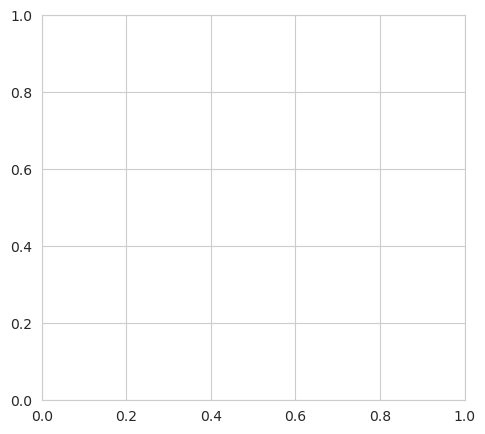

In [ ]:
# Configurações
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNNLSTM(num_classes=4)  # Substitua pelo modelo desejado
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
epochs = 30
save_path = f"Models/Task1/frames/modelo_treinado_CNNLSTM_{epochs}_epocs.pth"

batch_size = 32  # Ajuste o tamanho do batch conforme necessário

train_losses, train_accuracies, val_losses, val_accuracies = train_temporal_model(
    model, seq_train_loader, seq_val_loader, criterion, optimizer, epochs, device, save_path
)

# Plotar os gráficos
plt.figure(figsize=(12, 5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_losses)+1), train_losses, label='Train Loss')
plt.plot(range(1, len(val_losses)+1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss (Temporal Model)')
plt.legend()

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, epochs + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy (Temporal Model)')
plt.legend()

plt.tight_layout()
plt.show()

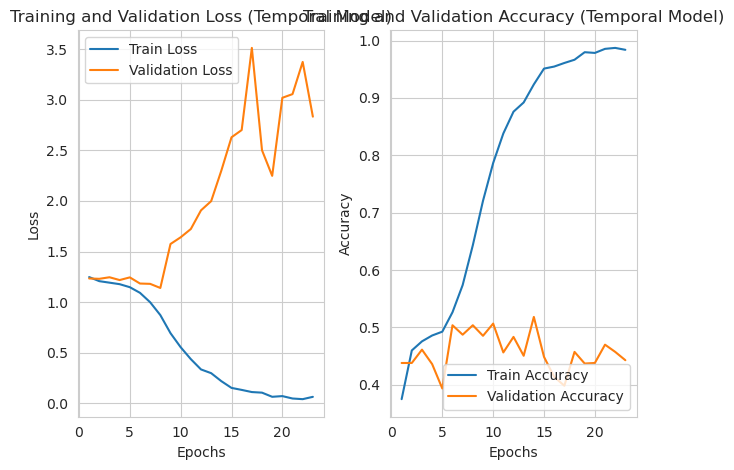

In [53]:
# Loss
plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_losses)+1), train_losses, label='Train Loss')
plt.plot(range(1, len(val_losses)+1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss (Temporal Model)')
plt.legend()

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy (Temporal Model)')
plt.legend()

plt.tight_layout()
plt.show()

In [54]:
def evaluate_video_level(model, test_loader, device):
    """Avalia o modelo por vídeo completo, agregando previsões de sequências."""
    model.to(device)
    model.eval()
    
    # Dicionário para armazenar previsões por vídeo
    video_predictions = {}
    video_labels = {}
    
    with torch.no_grad():
        for inputs, labels, video_ids in test_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            
            # Armazenar previsões para cada vídeo
            for i, video_id in enumerate(video_ids):
                if video_id not in video_predictions:
                    video_predictions[video_id] = []
                    video_labels[video_id] = labels[i].item()
                    
                video_predictions[video_id].append(predicted[i].cpu().item())
    
    # Agregar previsões por vídeo (votação majoritária)
    final_predictions = []
    final_labels = []
    
    for video_id, preds in video_predictions.items():
        # Contagem de previsões
        pred_counts = np.bincount(preds)
        final_pred = np.argmax(pred_counts)
        
        final_predictions.append(final_pred)
        final_labels.append(video_labels[video_id])
    
    # Calcular métricas
    from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
    
    accuracy = accuracy_score(final_labels, final_predictions)
    print(f"Accuracy por Vídeo: {accuracy:.4f}")
    
    # Matriz de confusão
    cm = confusion_matrix(final_labels, final_predictions)
    print("Relatório de Classificação por Vídeo:")
    print(classification_report(final_labels, final_predictions))
    
    # Visualização da matriz de confusão
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
                xticklabels=np.unique(final_labels), 
                yticklabels=np.unique(final_labels))
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Matriz de Confusão (Nível de Vídeo)")
    plt.show()
    
    return accuracy

/tmp/ipykernel_65939/145859252.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(save_path))


Accuracy por Vídeo: 0.4516
Relatório de Classificação por Vídeo:
              precision    recall  f1-score   support

           0       0.42      0.45      0.43        11
           1       0.50      0.14      0.22         7
           2       0.53      0.73      0.62        11
           3       0.00      0.00      0.00         2

    accuracy                           0.45        31
   macro avg       0.36      0.33      0.32        31
weighted avg       0.45      0.45      0.42        31



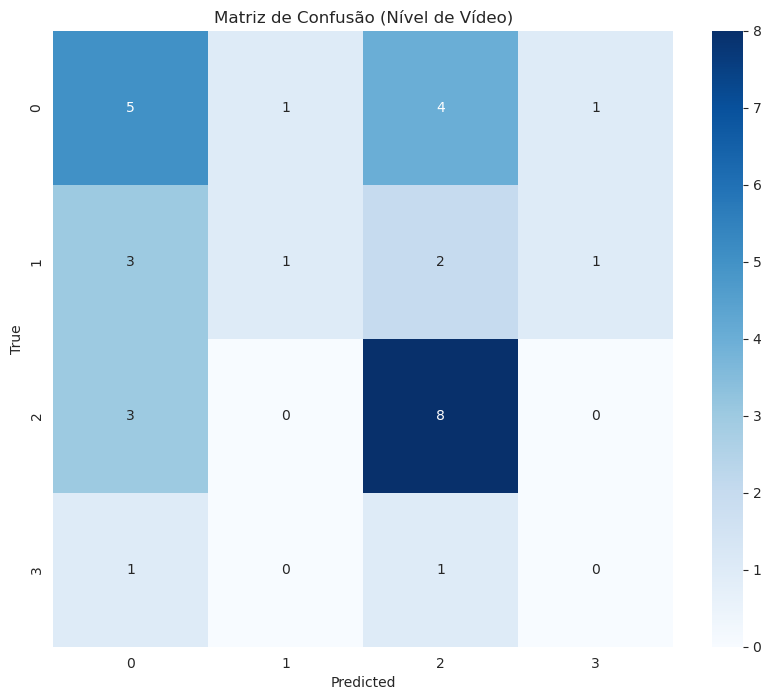

Accuracy final por vídeo: 0.4516


In [55]:
# Carregar o modelo treinado
model = CNNLSTM(num_classes=4)
model.load_state_dict(torch.load(save_path))


# Avaliar o modelo por vídeo
video_accuracy = evaluate_video_level(model, seq_test_loader, device)
print(f"Accuracy final por vídeo: {video_accuracy:.4f}")

v2/Models/Task1/frames/modelo_treinado_CNNLSTM_3_epocs.pth
   Models/Task1/frames/modelo_treinado_CNNLSTM_3_epocs.pth